In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/small-nice-data-dota2/small_nice_data.csv


In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/small-nice-data-dota2/small_nice_data.csv", index_col=0)

print(df.head())

print(df.describe())

print(df.isnull().sum())


   time  radiant_roshankill  radiant_Δroshankill  dire_roshankill  \
0     0                   0                    0                0   
1    60                   0                    0                0   
2   120                   0                    0                0   
3   180                   0                    0                0   
4   240                   0                    0                0   

   dire_Δroshankill  good_tower1  good_tower2  good_tower3  good_melee  \
0                 0            3            3            3           3   
1                 0            3            3            3           3   
2                 0            3            3            3           3   
3                 0            3            3            3           3   
4                 0            3            3            3           3   

   good_range  ...  radiant_buyback  dire_buyback  radiant_Δrunes  \
0           3  ...                0             0               1   
1 

In [3]:
from sklearn.model_selection import train_test_split

y = df['time']
X = df.drop(columns='time')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(131440, 82) (32860, 82) (131440,) (32860,)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(X_train_preprocessed.shape, X_test_preprocessed.shape)


(131440, 82) (32860, 82)


In [5]:
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee...
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', LinearRegression())])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8357
[LightGBM] [Info] Number of data points in the train set: 131440, number of used features: 82
[LightGBM] [Info] Start training from score 1072.303256
Train metrics: {'MSE': 1529.3173098366137, 'R2': 0.9971709783315048}
Test metrics: {'MSE': 1696.486451747004, 'R2': 0.9968239587872046}


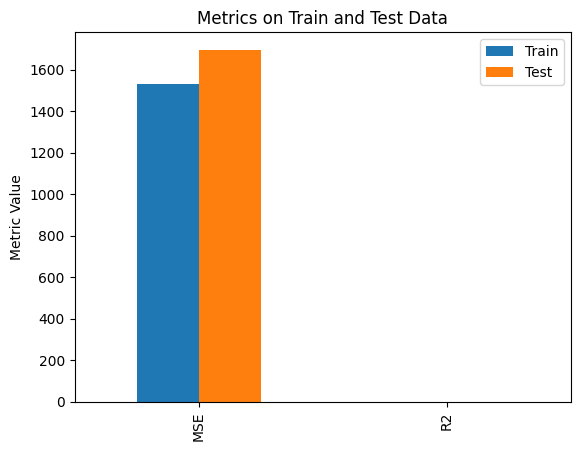

In [6]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

model = lgb.LGBMRegressor()
model.fit(X_train_preprocessed, y_train)

y_train_pred = model.predict(X_train_preprocessed)
y_test_pred = model.predict(X_test_preprocessed)

def get_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics = get_metrics(y_test, y_test_pred)

print("Train metrics:", train_metrics)
print("Test metrics:", test_metrics)

import matplotlib.pyplot as plt

metrics_df = pd.DataFrame({'Train': list(train_metrics.values()), 'Test': list(test_metrics.values())}, index=train_metrics.keys())
metrics_df.plot(kind='bar')
plt.title("Metrics on Train and Test Data")
plt.ylabel("Metric Value")
plt.show()


In [7]:
import joblib
joblib.dump(model, 'dota2_match_duration_model.pkl')
loaded_model = joblib.load('dota2_match_duration_model.pkl')

example_data = X_test.iloc[:5, :]
example_pred = loaded_model.predict(example_data)

print("Predictions:", example_pred)
print("Actual durations:", y_test.iloc[:5].values)


Predictions: [1859.29675176 1389.68516902  771.98208006 2069.75717708 1169.63155715]
Actual durations: [1860 1500  780 2040 1140]
